# Tarea 5: Construcción de la Red de sensores/subestaciones

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

ruta_csv = "data/ener_clean.csv" 

df = pd.read_csv(ruta_csv)

required_cols = ["Source_Node", "Target_Node"]
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"No encontré la columna '{col}'. Columnas disponibles: {list(df.columns)}")


# CREAR GRAFO DIRIGIDO

G = nx.DiGraph()

# Agregar aristas
for _, row in df.iterrows():
    G.add_edge(row["Source_Node"], row["Target_Node"])

print("Número de nodos:", G.number_of_nodes())
print("Número de aristas:", G.number_of_edges())




Número de nodos: 70
Número de aristas: 865


#### CENTRALIDAD DE GRADO Y BETWEENNESS CENTRALITY

In [2]:
degree_centrality = nx.degree_centrality(G)

betweenness_centrality = nx.betweenness_centrality(G)

# Convertir a DataFrame para ordenar
centrality_df = pd.DataFrame({
    "Node": list(G.nodes()),
    "Degree_Centrality": [degree_centrality[n] for n in G.nodes()],
    "Betweenness_Centrality": [betweenness_centrality[n] for n in G.nodes()]
})

centrality_df = centrality_df.sort_values(by="Betweenness_Centrality", ascending=False)

print("\nTop 10 nodos por Betweenness Centrality:")
print(centrality_df.head(10))


Top 10 nodos por Betweenness Centrality:
     Node  Degree_Centrality  Betweenness_Centrality
0   106.0           0.623188                     0.0
44  116.0           0.608696                     0.0
50  204.0           0.260870                     0.0
49  221.0           0.260870                     0.0
48  107.0           0.594203                     0.0
47  239.0           0.260870                     0.0
46  235.0           0.217391                     0.0
45  214.0           0.231884                     0.0
43  229.0           0.246377                     0.0
52  245.0           0.275362                     0.0


#### IDENTIFICAR NODO CUELLO DE BOTELLA


Nodo Cuello de Botella: 106.0
Betweenness Centrality: 0.0


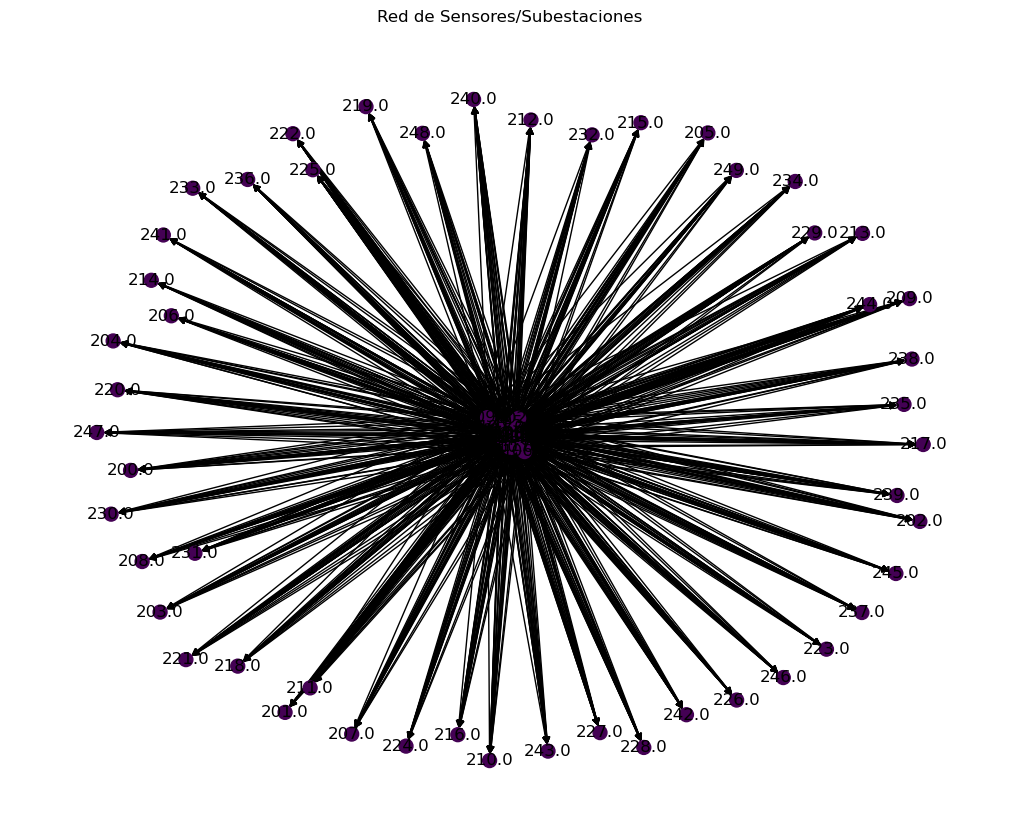

In [6]:
bottleneck_node = centrality_df.iloc[0]["Node"]
bottleneck_value = centrality_df.iloc[0]["Betweenness_Centrality"]

print("\nNodo Cuello de Botella:", bottleneck_node)
print("Betweenness Centrality:", bottleneck_value)


# VISUALIZACIÓN 

plt.figure(figsize=(10,8))
pos = nx.spring_layout(G, seed=42)

node_sizes = [5000 * betweenness_centrality[n] + 100 for n in G.nodes()]
node_colors = [betweenness_centrality[n] for n in G.nodes()]

nx.draw(G, pos,
        with_labels=True,
        node_size=node_sizes,
        node_color=node_colors,
        cmap=plt.cm.viridis,
        arrows=True)

plt.title("Red de Sensores/Subestaciones")
plt.show()